In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from matplotlib import pyplot as plt

import tensorflow as tf

In [2]:
boston = datasets.load_boston()

boston_x = boston.data
boston_y = boston.target

x_scaler = preprocessing.StandardScaler()
boston_x= x_scaler.fit_transform(boston_x)
boston_y = (boston_y - np.mean(boston_y)) / (np.var(boston_y))**(1/2)

train_x, test_x, train_y, test_y = model_selection.train_test_split(boston_x, boston_y, train_size=0.7, shuffle=True)

In [4]:
pd.DataFrame(boston_x).head()

0         1         2         3         4         5         6   \
0 -0.417713  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1 -0.415269 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2 -0.415272 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3 -0.414680 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4 -0.410409 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   

         7         8         9         10        11        12  
0  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562  
1  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439  
2  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727  
3  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517  
4  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501

In [5]:
pd.DataFrame(boston_y).head()

0
0  0.159686
1 -0.101524
2  1.324247
3  1.182758
4  1.487503

In [3]:
def model(features, labels, mode, params):

    h1 = tf.layers.dense(features["x"],
                         params['h1'],
                         activation = tf.nn.sigmoid,
                         kernel_initializer = tf.truncated_normal_initializer(stddev=1),
                         bias_initializer = tf.truncated_normal_initializer(stddev=1))

    drop = tf.layers.dropout(h1,
                             rate = params['drop'],
                             training = (mode == tf.estimator.ModeKeys.TRAIN))

    h2 = tf.layers.dense(drop,
                         20,
                         activation=tf.nn.sigmoid,
                         kernel_initializer=tf.truncated_normal_initializer(stddev=1),
                         bias_initializer=tf.truncated_normal_initializer(stddev=1))
    
    h3 = tf.layers.dense(h2,
                         20,
                         activation=tf.nn.sigmoid,
                         kernel_initializer=tf.truncated_normal_initializer(stddev=1),
                         bias_initializer=tf.truncated_normal_initializer(stddev=1))

    h4 = tf.layers.dense(h3,
                         1,
                         activation=None,
                         kernel_initializer=tf.truncated_normal_initializer(stddev=1),
                         bias_initializer=tf.truncated_normal_initializer(stddev=1))

    prediction = tf.reshape(h4, [-1])

    if mode == tf.estimator.ModeKeys.PREDICT :
        return tf.estimator.EstimatorSpec(mode=mode, predictions={'result' :prediction})
        
    loss = tf.losses.mean_squared_error(tf.squeeze(h4), labels)
    
    acc = tf.metrics.accuracy(labels, prediction)
    metric = tf.metrics.root_mean_squared_error(labels, prediction)
    
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['lr'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    eval_metric = {"metric" :metric }
    
#     tf.summary.scalar("RMS", metric[1])
#     tf.summary.scalar("ACCURACY",acc[1])
    
    if mode == tf.estimator.ModeKeys.EVAL :
        return tf.estimator.EstimatorSpec(mode=mode, eval_metric_ops=eval_metric, loss=loss)

    if mode == tf.estimator.ModeKeys.TRAIN :
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

In [4]:
train_fn = tf.estimator.inputs.numpy_input_fn({"x": train_x},
                                              train_y,
                                              batch_size=354,
                                              num_epochs=5000,
                                              shuffle=False)

params = {"h1": 15, "drop": 0, "lr": 0.01}
config = tf.contrib.learn.RunConfig(keep_checkpoint_max=1, model_dir='./dir/Boston5', )

nn = tf.estimator.Estimator(model_fn=model, params=params, config=config)

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000000010FF0CC0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './dir/Boston5'}


In [ ]:
while True:
    nn.train(train_fn)
    nn.evaluate(tf.estimator.inputs.numpy_input_fn({'x' : test_x},test_y,shuffle=False))

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./dir/Boston5\model.ckpt.
INFO:tensorflow:loss = 2.146938, step = 1
INFO:tensorflow:global_step/sec: 101.209
INFO:tensorflow:loss = 0.95219445, step = 101 (0.996 sec)
INFO:tensorflow:global_step/sec: 163.925
INFO:tensorflow:loss = 0.718034, step = 201 (0.607 sec)
INFO:tensorflow:global_step/sec: 151.506
INFO:tensorflow:loss = 0.6308267, step = 301 (0.680 sec)
INFO:tensorflow:global_step/sec: 157.969
INFO:tensorflow:loss = 0.57866627, step = 401 (0.616 sec)
INFO:tensorflow:global_step/sec: 163.657
INFO:tensorflow:loss = 0.53593296, step = 501 (0.611 sec)
INFO:tensorflow:global_step/sec: 192.667
INFO:tensorflow:loss = 0.49793333, step = 601 (0.514 sec)
INFO:tensorflow:global_step/sec: 147.267
INFO:tensorflow:loss = 0.46372873, step = 701 (0.680 sec)
INFO:tensorflow:global_step/sec: 192.297
INFO:tensorflow:loss = 0.43310124, step = 801 (0.522 sec)
INFO:tensorflow:global_step/sec: 167.215
INFO:tensorf

INFO:tensorflow:loss = 0.118052125, step = 7601 (0.557 sec)
INFO:tensorflow:global_step/sec: 192.667
INFO:tensorflow:loss = 0.11725191, step = 7701 (0.518 sec)
INFO:tensorflow:global_step/sec: 217.379
INFO:tensorflow:loss = 0.11647323, step = 7801 (0.461 sec)
INFO:tensorflow:global_step/sec: 149.692
INFO:tensorflow:loss = 0.115715325, step = 7901 (0.673 sec)
INFO:tensorflow:global_step/sec: 190.465
INFO:tensorflow:loss = 0.11497739, step = 8001 (0.527 sec)
INFO:tensorflow:global_step/sec: 181.808
INFO:tensorflow:loss = 0.11425864, step = 8101 (0.542 sec)
INFO:tensorflow:global_step/sec: 223.202
INFO:tensorflow:loss = 0.11355837, step = 8201 (0.448 sec)
INFO:tensorflow:global_step/sec: 199.988
INFO:tensorflow:loss = 0.11287593, step = 8301 (0.500 sec)
INFO:tensorflow:global_step/sec: 213.663
INFO:tensorflow:loss = 0.11221063, step = 8401 (0.469 sec)
INFO:tensorflow:global_step/sec: 218.328
INFO:tensorflow:loss = 0.1115619, step = 8501 (0.458 sec)
INFO:tensorflow:global_step/sec: 205.75


INFO:tensorflow:Finished evaluation at 2018-02-11-16:03:44
INFO:tensorflow:Saving dict for global step 15000: global_step = 15000, loss = 0.19107704, metric = 0.3786767
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./dir/Boston5\model.ckpt-15000
INFO:tensorflow:Saving checkpoints for 15001 into ./dir/Boston5\model.ckpt.
INFO:tensorflow:loss = 0.08832056, step = 15001
INFO:tensorflow:global_step/sec: 193.787
INFO:tensorflow:loss = 0.088103145, step = 15101 (0.519 sec)
INFO:tensorflow:global_step/sec: 240.371
INFO:tensorflow:loss = 0.087887466, step = 15201 (0.416 sec)
INFO:tensorflow:global_step/sec: 232.005
INFO:tensorflow:loss = 0.08767343, step = 15301 (0.431 sec)
INFO:tensorflow:global_step/sec: 232.005
INFO:tensorflow:loss = 0.08746102, step = 15401 (0.432 sec)
INFO:tensorflow:global_step/sec: 231.468
INFO:tensorflow:loss = 0.08725018, step = 15501 (0.431 sec)
INFO:tensorflow:global_step/sec: 248.742
INFO:tensorflow:loss = 0.087040834, step =

INFO:tensorflow:loss = 0.0752499, step = 22201 (0.539 sec)
INFO:tensorflow:global_step/sec: 198.008
INFO:tensorflow:loss = 0.07509064, step = 22301 (0.506 sec)
INFO:tensorflow:global_step/sec: 181.808
INFO:tensorflow:loss = 0.07493178, step = 22401 (0.554 sec)
INFO:tensorflow:global_step/sec: 212.754
INFO:tensorflow:loss = 0.07477334, step = 22501 (0.466 sec)
INFO:tensorflow:global_step/sec: 190.465
INFO:tensorflow:loss = 0.0746153, step = 22601 (0.526 sec)
INFO:tensorflow:global_step/sec: 176.981
INFO:tensorflow:loss = 0.07445766, step = 22701 (0.562 sec)
INFO:tensorflow:global_step/sec: 207.028
INFO:tensorflow:loss = 0.07430044, step = 22801 (0.485 sec)
INFO:tensorflow:global_step/sec: 198.796
INFO:tensorflow:loss = 0.07414361, step = 22901 (0.502 sec)
INFO:tensorflow:global_step/sec: 210.072
INFO:tensorflow:loss = 0.073987186, step = 23001 (0.476 sec)
INFO:tensorflow:global_step/sec: 239.221
INFO:tensorflow:loss = 0.073831156, step = 23101 (0.418 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:Restoring parameters from ./dir/Boston4\model.ckpt-45002


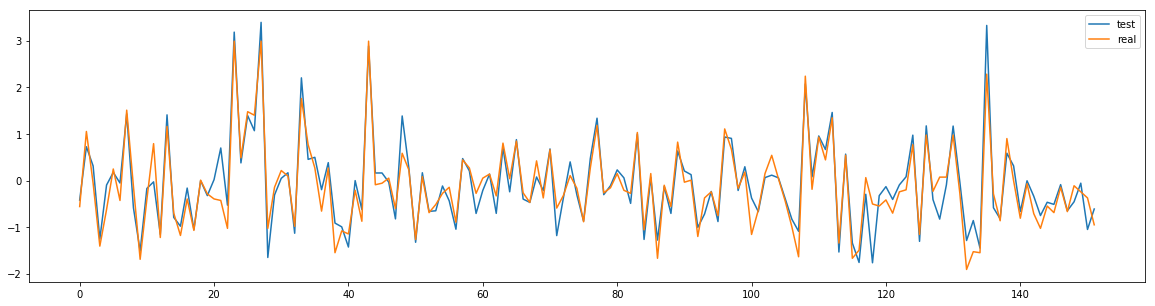

In [10]:
pred_y = nn.predict(tf.estimator.inputs.numpy_input_fn({"x":test_x},shuffle=False,num_epochs=1))
plt.figure(figsize=(20,5))
plt.plot([y['result'] for y in pred_y],label='test')
plt.plot(test_y,label='real')
plt.legend()
plt.show()

INFO:tensorflow:Restoring parameters from ./dir/Boston4\model.ckpt-45002


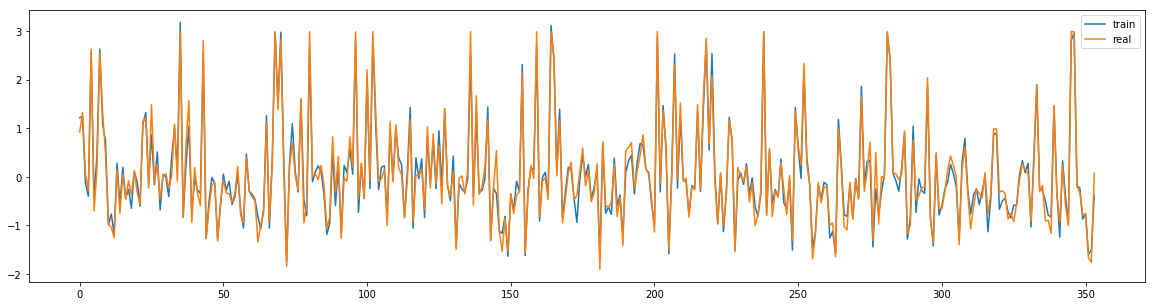

In [11]:
pred_y = nn.predict(tf.estimator.inputs.numpy_input_fn({"x":train_x},shuffle=False))
plt.figure(figsize=(20,5))
plt.plot([y['result'] for y in pred_y],label='train')
plt.plot(train_y,label='real')
plt.legend()
plt.show()